In [3]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import gc
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pywt, librosa 
import multiprocessing
from multiprocessing import Pool
import time
import math
from sklearn.preprocessing import StandardScaler
import random

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Training on GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Training on CPU")

cpu_count = multiprocessing.cpu_count()
print(cpu_count)

np.set_printoptions(threshold=np.inf)

Training on GPU: NVIDIA GeForce RTX 3080 Laptop GPU
16


In [4]:
sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [5]:
from config.constants import *
from viz.plot import *
from features.statistical_features import*
from tracking.save_log import *
from features.process_eeg import*

Seperating into 10s?
4 or 5 channels?
all 19 channals?


hop_length = len(x)//final_length. final_length = 1000? then hop_length= 10, however win_length should be sufficient
Combination of win_length = 256, 512,1024?  n_mels = 16?

Try: Samller hop length + larger win_size?


In [4]:

class CFG:
    seed = 48
    debug = False
    one_fold = False


    model_name = "tf_efficientnet_b0_ns"
    n_fold = 5
    epochs = 300
    batch_size = 64    
    lr = 0.0001
    L1 = 0.0001
    
torch.manual_seed(CFG.seed)
np.random.seed(CFG.seed)
random.seed(CFG.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CFG.seed)
    
READ_EEG_DIC = True
GENERATE_SAMPLER_FROM_EEG = False
GENERATE_DATA = True
SAVE_SATA = True
READ_INDIVIDUAL_SPE=False
COMBINE_CHANNELS = False
READ_SAMPLER_DIRECTLY = False

In [5]:
NEW_DF = pd.read_csv(f"{PROCESSED_DATA_DIR}/train_df.csv")


In [6]:
filtered_csv_path =  f"{PROCESSED_DATA_DIR}/filtered_df_probabilities.csv"
filtered_df = pd.read_csv(filtered_csv_path)
print(filtered_df.shape)
filtered_df.head()

(28387, 16)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,level_1
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,0
1,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,6
2,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0.0,0.0000,0.454545,0.000,0.090909,0.454545,9
3,722738444,0,0.0,999431,0,0.0,557980729,56885,LRDA,0.0,0.0625,0.000000,0.875,0.000000,0.062500,11
4,387987538,0,0.0,1084844,0,0.0,4099147263,4264,LRDA,0.0,0.0000,0.000000,1.000,0.000000,0.000000,22


In [7]:
if READ_EEG_DIC:
    eeg_montage_path = f"{PROCESSED_DATA_DIR}/eeg_data_dict.pickle"
    with open(eeg_montage_path, 'rb') as handle:
        eeg_data_dict = pickle.load(handle)

In [8]:
COMBINE_EEG_VOTES = False
if COMBINE_EEG_VOTES:
    TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    
    NEW_DF = NEW_DF.set_index('eeg_id')
    for index, (key, value) in enumerate(eeg_data_dict.items()):
        eeg_id = int(value["eeg_id"])
        
        
        new_targets = NEW_DF.loc[eeg_id, TARGETS].values
        
        value['targets'] = np.array(new_targets)
        if (index + 1) % 500 == 0:
            print(f"Processed {index + 1} samples.")

In [9]:
#新增存单独SPE#####
######################

# target_dir = os.path.join(PROCESSED_DATA_DIR, 'single_stft_spe_10')
# os.makedirs(target_dir, exist_ok=True)

# # 循环处理eeg_data_dict中的数据
# for index, (key, value) in enumerate(eeg_data_dict.items()):
#     # 假设你想分批处理，你可以通过简单地限制循环的迭代来实现
#     # 例如，只处理前7000个数据
#     if index >= 30000000:
#         break  # 当处理了7000个数据后停止
    
#     data = value['data']
#     processed_stft_data_not_standarlized = spectrogram_from_eeg_stft_9plu_ekg(data, spe_width=1024, n_fft=1024, spe_win=512, display=False)
#     targets = value['targets']
    
#     # 将数据和目标封装到字典中
#     data_to_save = {'data': processed_stft_data_not_standarlized, 'targets': targets}
    
#     # 定义保存文件的路径
#     file_path = os.path.join(target_dir, f'stft_spe_{index}.pkl')  # 注意这里使用了index作为文件名的一部分
    
#     # 使用pickle保存数据
#     with open(file_path, 'wb') as f:
#         pickle.dump(data_to_save, f)

#     if (index + 1) % 500 == 0:
#         print(f"Processed and saved {index + 1} samples.")




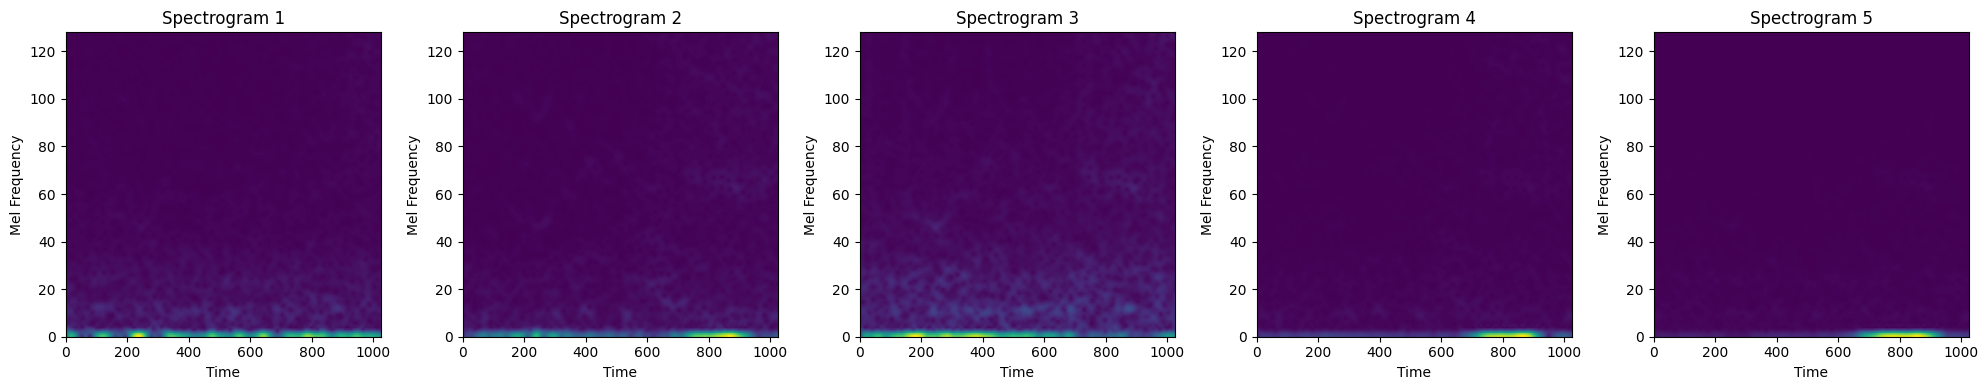

In [9]:
if GENERATE_DATA:
#VISUALIZE 1ST ELEMENT
    first_key = list(eeg_data_dict.keys())[0]  # 获取第一个键名
    data_to_process = eeg_data_dict[first_key]["data"]

    processed_img_stft_sample = spectrogram_from_eeg_stft_trans_bi(data_to_process,display=True)

In [11]:
#失败的多核心
# def process_sample(sample_data):
#     key, value = sample_data
#     data = value['data']
#     processed_data = spectrogram_from_eeg_stft(data, spe_width=1024, n_fft=1024, spe_win=256, display=False)
#     processed_data = np.nan_to_num(processed_data, nan=0.0)
    
#     mn = processed_data.flatten().min()
#     mx = processed_data.flatten().max()
#     ep = 1e-5
#     processed_data = (processed_data - mn) / (mx - mn + ep)
    
#     targets = value['targets']
#     processed_sample = []
    
#     for i in range(processed_data.shape[2]):  # 5 channels
#         single_channel_data = processed_data[:, :, i]
#         sampler_result = SAMPLERrep_ver2(single_channel_data, axis=1)
#         processed_sample.append(sampler_result)
    
#     flattened_sample = np.concatenate([np.ravel(sample) for sample in processed_sample])
#     #return np.concatenate([flattened_sample, targets]), processed_data
#     return np.concatenate([flattened_sample, targets])

# if GENERATE_DATA:
#     processed_sampler_data = []
#     #standardized_processed_data = []

#     with Pool(processes=4) as pool:
#         results = pool.map(process_sample, eeg_data_dict.items())
#         for sampler_result in results:
#             processed_sampler_data.append(sampler_result)

# else:
#     spe_sampler_50s_data_dict_path = f"{PROCESSED_DATA_DIR}/spe_sampler_50s_data_dict.pickle"
#     with open(spe_sampler_50s_data_dict_path, 'rb') as handle:
#         processed_sampler_data = pickle.load(handle)
#     print(len(processed_sampler_data))


In [10]:
unique_eeg_ids_first_occurrence = filtered_df.drop_duplicates(subset=['eeg_id']).index.tolist()

In [11]:
if GENERATE_SAMPLER_FROM_EEG:
    processed_sampler_data = []
    for index, (key, value) in enumerate(eeg_data_dict.items()):
        if not index in unique_eeg_ids_first_occurrence:
            continue
        
        data =  value['data'].to_numpy()
        
        mean_value = np.nanmean(data)
        data[np.isnan(data)] = mean_value
        
        
        processed_data = data
        
        mn = processed_data.min()
        mx = processed_data.max()
        ep = 1e-5
        processed_data= (processed_data - mn) / (mx - mn + ep)
        
        processed_data = SAMPLERrep_ver2(processed_data, axis=0)
        
        flattened_sample = np.ravel(processed_data)
        
        targets = value['targets']
        
        processed_sampler_data.append(np.concatenate([flattened_sample, targets]))
        
        
        if (index + 1) % 500 == 0:
            print(f"Processed {index + 1} samples.")

In [12]:
if GENERATE_DATA:
    processed_sampler_data = []
    for index, (key, value) in enumerate(eeg_data_dict.items()):
        if not index in unique_eeg_ids_first_occurrence:
            continue
        data = value['data']
        
        processed_data =  spectrogram_from_eeg_stft(data, spe_width = 1024, n_fft=1024, spe_win = 128, display=False)
        #processed_data = spectrogram_from_eeg_stft( data, spe_width = 1000, n_fft=1024, spe_win = 512,display=False )
        #processed_data = spectrogram_from_eeg_stft_trans_bi( data, spe_width = 1000, n_fft=1024, spe_win = 512,display=False )
        
        processed_data = np.nan_to_num(processed_data, nan=0.0) 
        
        # mn = processed_data.min()
        # mx = processed_data.max()
        # ep = 1e-5
        # processed_data= (processed_data - mn) / (mx - mn + ep)
        
        targets = value['targets']
        
        processed_sample = []
        
        for i in range(processed_data.shape[2]):  # 5 channels
            single_channel_data = processed_data[:, :, i]
            sampler_result = SAMPLERrep_ver2(single_channel_data, axis=1)
            processed_sample.append(sampler_result)
        
        flattened_sample = np.concatenate([np.ravel(sample) for sample in processed_sample])
        processed_sampler_data.append(np.concatenate([flattened_sample, targets]))
        
        
        if (index + 1) % 1000 == 0:
            print(f"Processed {index + 1} samples.")

elif READ_INDIVIDUAL_SPE:
    processed_sampler_data = []
    path = f"{PROCESSED_DATA_DIR}/single_stft_spe_10"
    spe_dicts= os.listdir(path) 
    
    sorted_files = sorted(spe_dicts, key=lambda x: int(x.split('_')[-1].split('.')[0]))
 

    for index,spe_dict in enumerate(sorted_files):
        if not index in unique_eeg_ids_first_occurrence:
            continue
        
        full_path = os.path.join(path, spe_dict)
        
        with open(full_path, 'rb') as handle:
            spe = pickle.load(handle)
        targets = spe["targets"]
        data = spe['data']

        # processed_data = np.nan_to_num(processed_data, nan=0.0) 
        
        # mn = processed_data.min()
        # mx = processed_data.max()
        # ep = 1e-5
        # processed_data= (processed_data - mn) / (mx - mn + ep)
        
        #calculate power
        #data = np.square(data)

        data = data[:, :, :9]  # 现在data的形状为[x, y, 9]
        
        combined_data = np.empty((data.shape[0], data.shape[1], 5))
        
        for i in range(4):
            combined_data[:, :, i] = data[:, :, i*2] + data[:, :, i*2 + 1]
            
        combined_data[:, :, 4] = data[:, :, 8]

        #我不分别standardize 啦！！！
        #processed_data = standardize_spe_z_score_per_feature(combined_data)
        processed_data = combined_data
        
        processed_sample = []
        
        for i in range(processed_data.shape[2]):  # 10 channels
            single_channel_data = processed_data[:, :, i]
            sampler_result = SAMPLERrep_ver2(single_channel_data, axis=1)
            processed_sample.append(sampler_result)
        
        flattened_sample = np.concatenate([np.ravel(sample) for sample in processed_sample])
        processed_sampler_data.append(np.concatenate([flattened_sample, targets]))

        
        if (index + 1) % 500 == 0:
            print(f"Processed {index + 1} samples.")
    
    
    
if READ_SAMPLER_DIRECTLY:

    spe_sampler_50s_data_dict_path = f"{PROCESSED_DATA_DIR}/not_standarlized_stft.pickle"
    with open(spe_sampler_50s_data_dict_path, 'rb') as handle:
        processed_sampler_data = pickle.load(handle)
    print(len(processed_sampler_data))


Processed 1000 samples.
Processed 2000 samples.
Processed 5000 samples.
Processed 8000 samples.
Processed 10000 samples.
Processed 14000 samples.
Processed 15000 samples.
Processed 18000 samples.
Processed 20000 samples.
Processed 22000 samples.
Processed 23000 samples.
Processed 24000 samples.
Processed 25000 samples.
Processed 26000 samples.
Processed 27000 samples.


In [54]:
processed_data.shape

(144, 1024, 5)

In [48]:
#字典生成花了很长时间，没有逐一读取
#spectrogram_from_eeg_stft(data, spe_width = 1024, n_fft=1024, spe_win = 512, display=False):
#processed_data.shape (144, 1024, 5)
spe_sampler_50s_data_dict_path = f"{PROCESSED_DATA_DIR}/not_standarlized_stft_2.pickle"
with open(spe_sampler_50s_data_dict_path, 'rb') as handle:
    processed_sampler_data_1 = pickle.load(handle)
processed_sampler_data_1 = np.array(processed_sampler_data_1)


spe_sampler_50s_data_dict_path_2 = f"{PROCESSED_DATA_DIR}/not_standarlized_stft.pickle"
with open(spe_sampler_50s_data_dict_path_2, 'rb') as handle:
    processed_sampler_data_2 = pickle.load(handle)

processed_sampler_data_2_10to5 = np.array(processed_sampler_data_2)

In [50]:
are_columns_equal = np.allclose(processed_sampler_data_1[:, :2], processed_sampler_data_2_10to5[:, :2], atol=0.01)

print("前两列完全一致吗？", are_columns_equal)

前两列完全一致吗？ False


In [53]:
processed_sampler_data_2_10to5 [ : 100 , 1]

array([ 3782.94816895,  2590.83334961,  5862.56494141,  3271.84932861,
        3186.39758301,  2848.84421387,  2779.82081299,  6141.77541504,
        8397.92871094,  6362.15327148,  9283.25522461,  8462.73613281,
        8332.07607422, 10876.87172852,  4842.92451172,  7693.54394531,
        2879.49564209,  5644.70559082,  6108.37861328,  5137.69733887,
        3378.38587646,  3263.18494873,  5305.03303223,  9527.71875   ,
        2577.92869873,  1474.28026123,  4340.7932373 ,  3635.08796387,
        1676.36907349,  1801.43956299,  4252.25488281,  9259.75546875,
        2872.92520752,  2666.18425293,  2398.9548584 ,  3411.5026001 ,
        6126.67763672,  6131.58410645, 10525.54394531,  7301.28376465,
       14122.38793945, 10159.95698242,  7424.42285156, 43880.86894531,
        4937.21008301,  5555.44418945,  4550.00061035,  7122.36196289,
         546.13551636, 12123.09355469, 12074.43623047,  5500.17531738,
        6214.8125    ,  4921.50229492,  4139.00092773,  4193.7911377 ,
      

In [57]:
eeg_data_dict_2 = {}
eeg_id = "3911565283"
test_path = f"{RAW_DATA_DIR}/test_eegs/3911565283.parquet"
test_eeg = pd.read_parquet(test_path)

eeg_50s = test_eeg.iloc[0*200:50*200]#行数不够怎么办

transformed_eeg_np = montage_transform_banana(eeg_50s)
eeg_data_dict_2[eeg_id] = transformed_eeg_np



In [60]:
test_sampler_data = []

for index, (key, value) in enumerate(eeg_data_dict_2.items()):
    if not index in unique_eeg_ids_first_occurrence:
        continue
    data = value
    
    processed_data = spectrogram_from_eeg_stft(data)
    #processed_data = spectrogram_from_eeg_stft( data, spe_width = 1000, n_fft=1024, spe_win = 512,display=False )
    #processed_data = spectrogram_from_eeg_stft_trans_bi( data, spe_width = 1000, n_fft=1024, spe_win = 512,display=False )
    
    processed_data = np.nan_to_num(processed_data, nan=0.0) 
    
    # mn = processed_data.min()
    # mx = processed_data.max()
    # ep = 1e-5
    # processed_data= (processed_data - mn) / (mx - mn + ep)

    
    processed_sample = []
    
    for i in range(processed_data.shape[2]):  # 5 channels
        single_channel_data = processed_data[:, :, i]
        sampler_result = SAMPLERrep_ver2(single_channel_data, axis=1)
        processed_sample.append(sampler_result)
    
    flattened_sample = np.concatenate([np.ravel(sample) for sample in processed_sample])
    test_sampler_data.append(flattened_sample)

In [61]:
print(test_sampler_data[:100])

[array([8.73732901e+02, 9.61286288e+02, 9.12915714e+02, 7.20088147e+02,
       4.82842004e+02, 3.69899078e+02, 2.98948010e+02, 2.21186768e+02,
       1.85742970e+02, 1.44295446e+02, 1.40459847e+02, 1.24863036e+02,
       8.85711445e+01, 7.92356358e+01, 6.76794907e+01, 8.04574818e+01,
       7.82011108e+01, 7.61847595e+01, 7.11476559e+01, 6.34236841e+01,
       5.85953489e+01, 5.00094698e+01, 5.01643772e+01, 5.00573227e+01,
       5.39183399e+01, 5.63476490e+01, 5.35560390e+01, 5.42063505e+01,
       4.67224134e+01, 5.67440754e+01, 6.30015232e+01, 5.84342293e+01,
       6.27006378e+01, 7.07889965e+01, 6.73019508e+01, 5.34455915e+01,
       5.76045252e+01, 6.59761276e+01, 7.24702240e+01, 6.20249697e+01,
       6.58790653e+01, 6.38324589e+01, 6.19424116e+01, 6.24664997e+01,
       5.84615129e+01, 5.21819010e+01, 5.21689047e+01, 4.80389162e+01,
       5.15417500e+01, 5.78797291e+01, 5.25508745e+01, 4.88717112e+01,
       4.99742073e+01, 5.65614841e+01, 5.64393625e+01, 5.39858147e+01,
     

In [15]:
####！！！
####只选取那一万过个该死的不重复的eeg
# unique_eeg_ids_first_occurrence = filtered_df.drop_duplicates(subset=['eeg_id']).index.tolist()
# print(unique_eeg_ids_first_occurrence[:10])
# processed_sampler_data = [processed_sampler_data[i] for i in unique_eeg_ids_first_occurrence]
# print(len(processed_sampler_data))

In [16]:
print(len(processed_sampler_data))
input_dim = len(processed_sampler_data[0])-6
print(max(processed_sampler_data[0]))
print(input_dim)

17089
67827.792578125
7200


Create Dataset

In [47]:

if SAVE_SATA:
    log_feature_file(log_path =os.path.join(PROCESSED_DATA_DIR, "features_log.csv"), 
                     file_name = "not_standarlized_128_win.pickle", 
                     file_type = "Pickle", 
                     note = "individual not standarlized 2直接从eeg生成五个频道，我要对比", 
                     processed_sampler_data = processed_sampler_data, 
                     PROCESSED_DATA_DIR = PROCESSED_DATA_DIR)
    
    # log_feature_file(log_path =os.path.join(PROCESSED_DATA_DIR, "features_log.csv"), 
    #                 file_name = "spe_stft_50s_128*1024*5img.pickle", 
    #                 file_type = "Pickle", 
    #                 note = "spectrogram_from_eeg_stft( data, spe_width = 1024, n_fft=1024, spe_win = 512, display=False )", 
    #                 processed_sampler_data = standardized_processed_data, 
    #                 PROCESSED_DATA_DIR = PROCESSED_DATA_DIR)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, nhead, num_encoder_layers, num_decoder_layers, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)  # Embedding layer
        self.pos_encoder = PositionalEncoding(hidden_dim, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

    def forward(self, x):
        # Assuming x is of shape [batch_size, seq_len, input_dim]
        x = self.embedding(x)  # [batch_size, seq_len, hidden_dim]
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # Transformer expects [seq_len, batch_size, hidden_dim]
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Back to [batch_size, seq_len, hidden_dim]
        x = x.mean(dim=1)  # Aggregating over sequence
        x = self.fc_out(x)
        log_probs = F.log_softmax(x, dim=1)
        return log_probs

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [19]:
# USE_CNN = False
# class CustomDataset(Dataset):
    
#     def __init__(self, processed_sampler_data,standardize_fn=None):
#         self.processed_sampler_data = processed_sampler_data
#         self.standardize_fn = standardize_fn
#     def __len__(self):
#         return len(self.processed_sampler_data)
    
#     def __getitem__(self, index):
        
#         x = self.processed_sampler_data[index][:-6]
#         if self.standardize_fn is not None:
#             feature = self.standardize_fn(feature)
#         if USE_CNN:
#             feature = np.reshape(feature,(1,90,80))
#         x = torch.tensor(x, dtype=torch.float32)  

#         y = self.processed_sampler_data[index][-6:]
#         y = torch.tensor(y, dtype=torch.float32) 
#         return x, y

In [20]:
class CustomDataset(Dataset):
    
    def __init__(self, X,y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        
        x = self.X[index]
        y = self.y[index]

        x = torch.tensor(x, dtype=torch.float32)  
        y = torch.tensor(y, dtype=torch.float32) 
        return x, y

Create Multinomial LR Model

In [21]:
class SimpleMultinomialModelKL(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMultinomialModelKL, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        x = self.fc(x)
        log_probs = F.log_softmax(x, dim=1)  # log_softmax to fit KL-DIV
        return log_probs

In [22]:
class EnhancedMultinomialModelKL(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(EnhancedMultinomialModelKL, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        log_probs = F.log_softmax(x, dim=1)  # 使用log_softmax适配KL散度
        return log_probs


In [23]:
class SimpleMultinomialModelKL_2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMultinomialModelKL_2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        log_probs = F.log_softmax(x, dim=1)  # log_softmax to fit KL-DIV
        return log_probs


In [24]:
class SimpleCNNWithGlobalPooling(nn.Module):
    def __init__(self):
        super(SimpleCNNWithGlobalPooling, self).__init__()
        # 定义第一个卷积层
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # 定义第二个卷积层
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # 定义第三个卷积层，增加模型的深度
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # 全局平均池化层，注意: 不需要显式定义，可以在forward函数中使用F.adaptive_avg_pool2d
        # 定义全连接层，注意调整全连接层的输入特征数，因为卷积层的输出通道数现在是64
        self.fc = nn.Linear(64, 6)  # 64个输入特征，6个输出类别

    def forward(self, x):
        # 应用第一个卷积层后接ReLU激活函数
        x = F.relu(self.conv1(x))
        # 应用第二个卷积层后接ReLU激活函数
        x = F.relu(self.conv2(x))
        # 应用新增的第三个卷积层后接ReLU激活函数
        x = F.relu(self.conv3(x))
        # 应用全局平均池化
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # 展平特征图
        x = x.view(x.size(0), -1)
        # 应用全连接层得到最终的输出
        x = self.fc(x)
        log_probs = F.log_softmax(x, dim=1)  # 因为要用KL Divergence所以这里要乘以log softmax
        return log_probs



Train

Train Val Split and log

In [25]:
gc.collect()

0

In [26]:

# def train_eeg_spec_cus(processed_sampler_data, batch_size=64, lr=0.0001, epochs=200, random_state=46, device='cuda', save_model=False, save_path=os.path.join(CHECKPOINT_DIR, "{}.pth")):
#     processed_sampler_data = np.array(processed_sampler_data)
#     features = processed_sampler_data[:, :-6]
#     labels = processed_sampler_data[:, -6:]
    
#     # train test split
#     X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.3, random_state=random_state)
    
#     # dataset
#     train_dataset = CustomDataset(X_train, y_train)
#     val_dataset = CustomDataset(X_val, y_val)
    
#     # 创建DataLoader
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
#     # 定义模型列表
#     model_list = []
    
#     # 获取输入维度
#     sample_features, _ = next(iter(train_loader))
#     input_dim = sample_features.shape[1]
    
#     # 实例化模型并添加到列表
#     model_1 = SimpleMultinomialModelKL_2(input_dim=input_dim,hidden_dim=input_dim//2, output_dim=6).to(device)
#     model_1.name = "Simple LR 1 hidden layer"  # 存储模型名称
#     model_list.append(model_1)
    
#     # model_2 = SimpleMultinomialModelKL(input_dim=input_dim,hidden_dim=input_dim//2, output_dim=6).to(device)
#     # model_2.name = "SimpleMultinomialModelKL"  # 存储模型名称
#     # model_list.append(model_2)
    
#     #add list
#     train_loss_total = []
#     val_loss_total = []
    
#     for model in model_list:
#         # 为每个模型定义优化器
#         optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#         criterion = nn.KLDivLoss(reduction='batchmean').to(device)
        
#         # 进行训练和验证
#         Model_states, train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device)
        
#         log_training_results(log_path=LOG_PATH, 
#                              model_name=model.name,  # 使用模型的name属性
#                              params={'epoch': epochs, 'lr': lr, 'batch_size': batch_size}, 
#                              results={'val_loss': round(val_losses[-1], 4), 'train_loss': round(train_losses[-1], 4), 'F1': None, 'accuracy': None},
#                              random_state=random_state, 
#                              notes="最好的SAMPLER加上十个频道的psd")
#         if save_model:
#             # Save the model checkpoint
#             checkpoint = {
#                 "model_state": Model_states.state_dict(),
#                 "optimizer_state": optimizer.state_dict(),
#                 "epoch": epochs,
#                 "train_loss": train_losses,
#                 "val_loss": val_losses,
#             }
#             torch.save(checkpoint, save_path.format(model.name))
        
#         train_loss_total.append(train_losses)
#         val_loss_total.append(val_losses)
    
#     return model_list, train_loss_total, val_loss_total


In [27]:
def train_and_evaluate_L1(model, train_loader, valid_loader, optimizer, criterion, epochs, device, lambda_lasso = CFG.L1):
 
    def lasso_penalty(model, lambda_lasso):
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        return lambda_lasso * l1_norm
    
    model.train()
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    best_epoch = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        # 训练过程
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target) + lasso_penalty(model, lambda_lasso)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
            
        model.eval()  # 将模型设置为评估模式
        val_loss = 0
        with torch.no_grad():  # 在验证过程中不计算梯度
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)  # 在验证集上不加L1惩罚
                val_loss += loss.item()
                
        # 计算平均验证损失
        val_loss /= len(valid_loader)
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            
    # 返回训练后的模型，以及训练和验证损失的列表
    return model, train_losses, val_losses, best_val_loss, best_epoch



In [28]:
def train_and_evaluate(model, train_loader, valid_loader, optimizer, criterion, epochs, device):
    
    
    model.train()
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    best_epoch = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        # 训练过程
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            #target_log = torch.log(target+1e-8) 
            #loss = criterion(output, target) + lasso_penalty(model, lambda_lasso)
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
            
        model.eval()  # 将模型设置为评估模式
        val_loss = 0
        with torch.no_grad():  # 在验证过程中不计算梯度
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                #target_log = torch.log(target+1e-8)
                loss = criterion(output, target)
                val_loss += loss.item()
                
        # 计算平均验证损失
        val_loss /= len(valid_loader)
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
        
        if (epoch+1) % 2 == 0:
            print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            
    # 返回训练后的模型，以及训练和验证损失的列表
    return model, train_losses, val_losses, best_val_loss, best_epoch

In [29]:
processed_sampler_data = np.array(processed_sampler_data)
X = processed_sampler_data[:, :input_dim]
y = processed_sampler_data[:, input_dim:]

X = np.log1p(X)

In [30]:
def data_cleaning(X):
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1

    # 定义极端值的边界
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 替换极端值为中位数
    median = np.median(X, axis=0)
    X = np.where(X < lower_bound, median, X)
    X = np.where(X > upper_bound, median, X)
    return lower_bound, upper_bound, median, X

fold 0
Epoch: 2, Training Loss: 0.8294, Validation Loss: 0.8433
Epoch: 4, Training Loss: 0.6842, Validation Loss: 0.7987
Epoch: 6, Training Loss: 0.6509, Validation Loss: 0.7240
Epoch: 8, Training Loss: 0.5909, Validation Loss: 0.8265
Epoch: 10, Training Loss: 0.5493, Validation Loss: 0.7414
Epoch: 12, Training Loss: 0.5252, Validation Loss: 0.7052
Epoch: 14, Training Loss: 0.4887, Validation Loss: 0.7949
Epoch: 16, Training Loss: 0.4583, Validation Loss: 0.7827
Epoch: 18, Training Loss: 0.4205, Validation Loss: 0.7340
Epoch: 20, Training Loss: 0.4262, Validation Loss: 0.7506
Epoch: 22, Training Loss: 0.3943, Validation Loss: 0.7734
Epoch: 24, Training Loss: 0.3672, Validation Loss: 0.7360
Epoch: 26, Training Loss: 0.3758, Validation Loss: 0.8144
Epoch: 28, Training Loss: 0.3648, Validation Loss: 0.7442
Epoch: 30, Training Loss: 0.3202, Validation Loss: 0.7495
Epoch: 32, Training Loss: 0.3138, Validation Loss: 0.7891
Epoch: 34, Training Loss: 0.3168, Validation Loss: 0.8150
Epoch: 36, 

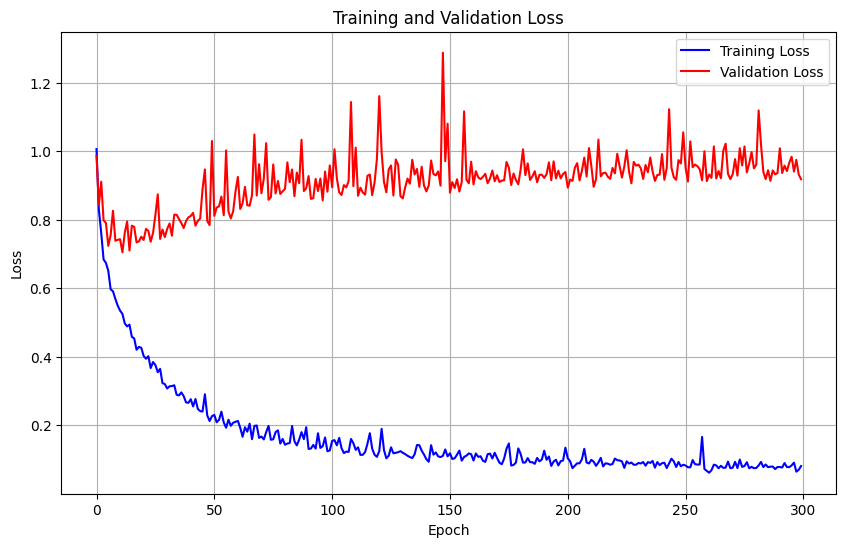

Fold 0: Best Validation Loss: 0.7052 at Epoch: 12
fold 1
Epoch: 2, Training Loss: 0.8075, Validation Loss: 1.0617
Epoch: 4, Training Loss: 0.6921, Validation Loss: 0.7668
Epoch: 6, Training Loss: 0.6256, Validation Loss: 0.8251
Epoch: 8, Training Loss: 0.5839, Validation Loss: 0.7972
Epoch: 10, Training Loss: 0.5422, Validation Loss: 0.7637
Epoch: 12, Training Loss: 0.5025, Validation Loss: 0.7959
Epoch: 14, Training Loss: 0.4970, Validation Loss: 0.7763
Epoch: 16, Training Loss: 0.4563, Validation Loss: 0.7826
Epoch: 18, Training Loss: 0.4362, Validation Loss: 0.8219
Epoch: 20, Training Loss: 0.3969, Validation Loss: 0.7428
Epoch: 22, Training Loss: 0.3856, Validation Loss: 0.8617
Epoch: 24, Training Loss: 0.3726, Validation Loss: 0.8618
Epoch: 26, Training Loss: 0.3483, Validation Loss: 1.0016
Epoch: 28, Training Loss: 0.3638, Validation Loss: 0.7942
Epoch: 30, Training Loss: 0.3211, Validation Loss: 0.7598
Epoch: 32, Training Loss: 0.3038, Validation Loss: 0.9892
Epoch: 34, Training

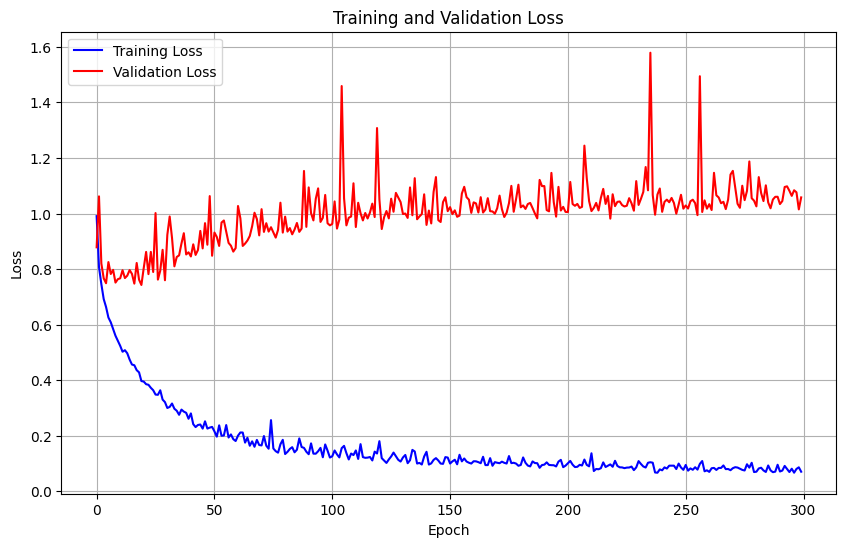

Fold 1: Best Validation Loss: 0.7428 at Epoch: 20
fold 2
Epoch: 2, Training Loss: 0.8249, Validation Loss: 0.9004
Epoch: 4, Training Loss: 0.6895, Validation Loss: 0.7707
Epoch: 6, Training Loss: 0.6365, Validation Loss: 0.7911
Epoch: 8, Training Loss: 0.5897, Validation Loss: 0.7326
Epoch: 10, Training Loss: 0.5516, Validation Loss: 0.6777
Epoch: 12, Training Loss: 0.5295, Validation Loss: 0.7353
Epoch: 14, Training Loss: 0.4876, Validation Loss: 0.7299
Epoch: 16, Training Loss: 0.4670, Validation Loss: 0.7046
Epoch: 18, Training Loss: 0.4457, Validation Loss: 0.7596
Epoch: 20, Training Loss: 0.4194, Validation Loss: 0.7041
Epoch: 22, Training Loss: 0.3937, Validation Loss: 0.7268
Epoch: 24, Training Loss: 0.3781, Validation Loss: 0.7273
Epoch: 26, Training Loss: 0.3538, Validation Loss: 0.7114
Epoch: 28, Training Loss: 0.3536, Validation Loss: 0.8128
Epoch: 30, Training Loss: 0.3149, Validation Loss: 0.7267
Epoch: 32, Training Loss: 0.3221, Validation Loss: 0.7968
Epoch: 34, Training

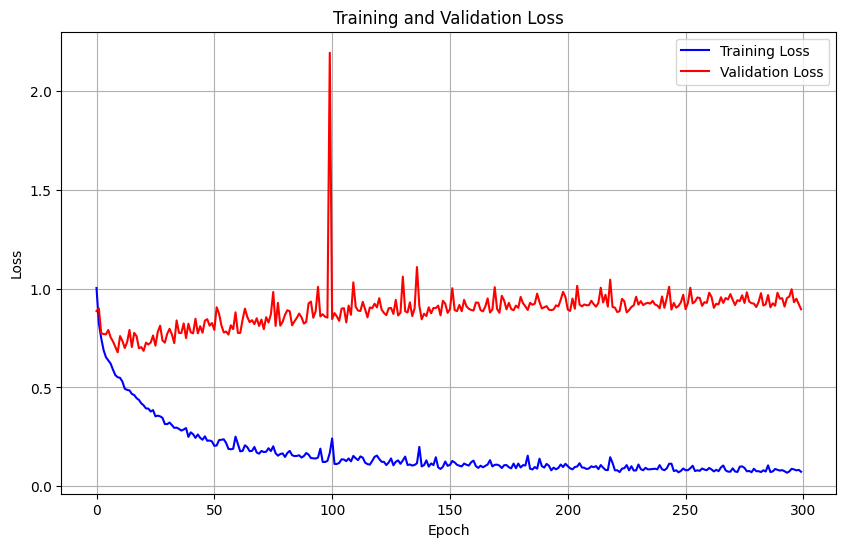

Fold 2: Best Validation Loss: 0.6777 at Epoch: 10
fold 3
Epoch: 2, Training Loss: 0.8225, Validation Loss: 0.8309
Epoch: 4, Training Loss: 0.6927, Validation Loss: 0.7710
Epoch: 6, Training Loss: 0.6226, Validation Loss: 0.7698
Epoch: 8, Training Loss: 0.5894, Validation Loss: 0.7675
Epoch: 10, Training Loss: 0.5547, Validation Loss: 0.7289
Epoch: 12, Training Loss: 0.5134, Validation Loss: 0.7173
Epoch: 14, Training Loss: 0.5072, Validation Loss: 0.7119
Epoch: 16, Training Loss: 0.4660, Validation Loss: 0.7549
Epoch: 18, Training Loss: 0.4445, Validation Loss: 0.8505
Epoch: 20, Training Loss: 0.4293, Validation Loss: 0.7575
Epoch: 22, Training Loss: 0.4027, Validation Loss: 0.7276
Epoch: 24, Training Loss: 0.3857, Validation Loss: 0.8000
Epoch: 26, Training Loss: 0.3520, Validation Loss: 0.7418
Epoch: 28, Training Loss: 0.3507, Validation Loss: 0.7238
Epoch: 30, Training Loss: 0.3201, Validation Loss: 0.7470
Epoch: 32, Training Loss: 0.3349, Validation Loss: 0.7924
Epoch: 34, Training

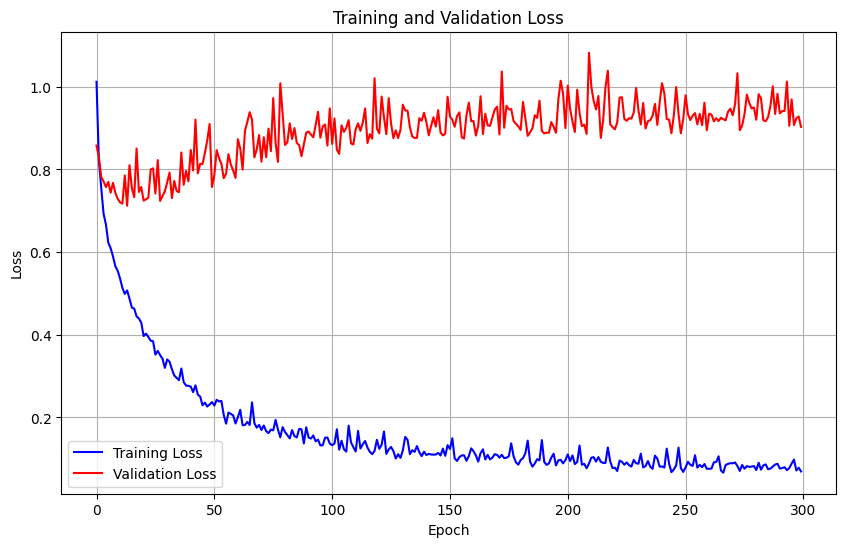

Fold 3: Best Validation Loss: 0.7119 at Epoch: 14
fold 4
Epoch: 2, Training Loss: 0.8157, Validation Loss: 0.8176
Epoch: 4, Training Loss: 0.7084, Validation Loss: 0.7938
Epoch: 6, Training Loss: 0.6358, Validation Loss: 0.6931
Epoch: 8, Training Loss: 0.5791, Validation Loss: 0.6813
Epoch: 10, Training Loss: 0.5648, Validation Loss: 0.6825
Epoch: 12, Training Loss: 0.5112, Validation Loss: 0.7052
Epoch: 14, Training Loss: 0.4815, Validation Loss: 0.6620
Epoch: 16, Training Loss: 0.4828, Validation Loss: 0.6540
Epoch: 18, Training Loss: 0.4471, Validation Loss: 0.6877
Epoch: 20, Training Loss: 0.4220, Validation Loss: 0.6981
Epoch: 22, Training Loss: 0.4119, Validation Loss: 0.6843
Epoch: 24, Training Loss: 0.3867, Validation Loss: 0.7573
Epoch: 26, Training Loss: 0.3708, Validation Loss: 0.7144
Epoch: 28, Training Loss: 0.3528, Validation Loss: 0.7063
Epoch: 30, Training Loss: 0.3326, Validation Loss: 0.6834
Epoch: 32, Training Loss: 0.3163, Validation Loss: 0.8134
Epoch: 34, Training

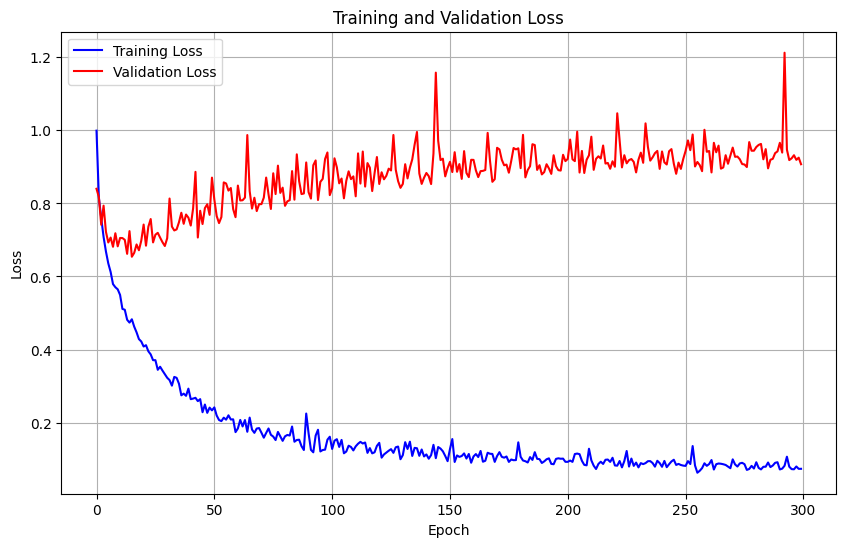

Fold 4: Best Validation Loss: 0.6540 at Epoch: 16


In [31]:



kf = KFold(n_splits=5, shuffle=True, random_state=CFG.seed)

l_best_loss = []
model_list = []



for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"fold {fold}")
    # 分割X和y为训练和验证集
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    #data cleaning
    lower_bound,upper_bound,median, X_train = data_cleaning(X_train)
    
    X_val = np.where(X_val < lower_bound, median, X_val)
    X_val = np.where(X_val > upper_bound, median, X_val)
    
    # 对每一折的训练数据计算均值和标准差
    scaler = StandardScaler().fit(X_train)
    
    # 标准化当前折的训练和验证数据
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # X_train_scaled = X_train
    # X_val_scaled = X_val
    
    # 接下来是构建train_ds和valid_ds
    # 注意，现在X_train_scaled和X_val_scaled应该用来构建相应的CustomDataset实例
    train_ds = CustomDataset(X_train_scaled, y_train)  # 假设CustomDataset可以接受X和y作为输入
    valid_ds = CustomDataset(X_val_scaled, y_val)
    
    train_loader = DataLoader(dataset=train_ds, shuffle=True, batch_size=CFG.batch_size)
    valid_loader = DataLoader(dataset=valid_ds,  shuffle=False,batch_size=64)
        
    model = SimpleMultinomialModelKL_2(input_dim, hidden_dim=(input_dim//2), output_dim=6).to(device)
    model.name = SimpleMultinomialModelKL_2
    
    
    # model = SimpleMultinomialModelKL(input_dim, output_dim=6).to (device)
    # model.name = "SimpleMultinomialModelKL"
    
    # model = TransformerModel(input_dim, hidden_dim = 512, output_dim = 6, nhead = 8, num_encoder_layers = 3, num_decoder_layers = 0).to(device)
    # model = SimpleMultinomialModelKL(input_dim,output_dim=6).to(device)
    # model.name = "SimpleMultinomialModelKL"
    
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
    criterion = nn.KLDivLoss(reduction='batchmean').to(device)
    
    
    model, train_losses, val_losses, best_val_loss, best_epoch = train_and_evaluate(
        model=model, 
        train_loader=train_loader, 
        valid_loader=valid_loader, 
        optimizer=optimizer, 
        criterion=criterion, 
        epochs=CFG.epochs, 
        device=device
    )
    model_list.append(model)
    plot_loss_curves(train_losses, val_losses, title='Training and Validation Loss', xlabel='Epoch', ylabel='Loss')
      
    l_best_loss.append(best_val_loss)
    print(f"Fold {fold}: Best Validation Loss: {best_val_loss:.4f} at Epoch: {best_epoch+1}")
    gc.collect()
log_training_results(log_path=LOG_PATH, 
                        model_name=model.name,  # 使用模型的name属性
                        params={'epoch': CFG.epochs, 'lr': CFG.lr, 'batch_size': CFG.batch_size}, 
                        results={'val_loss': round(sum(l_best_loss)/len(l_best_loss), 4), 'train_loss': "不想写", 'F1': None, 'accuracy': None},
                        random_state=CFG.seed, 
                        notes="Without L1 ,minmax, spectrogram_from_eeg(data)")

fold 0
Epoch: 2, Training Loss: 1.1403, Validation Loss: 1.1192
Epoch: 4, Training Loss: 1.0862, Validation Loss: 1.0814
Epoch: 6, Training Loss: 1.0484, Validation Loss: 1.0549
Epoch: 8, Training Loss: 1.0207, Validation Loss: 1.0449
Epoch: 10, Training Loss: 0.9972, Validation Loss: 1.0342
Epoch: 12, Training Loss: 0.9741, Validation Loss: 1.0087
Epoch: 14, Training Loss: 0.9539, Validation Loss: 1.0114
Epoch: 16, Training Loss: 0.9362, Validation Loss: 1.0085
Epoch: 18, Training Loss: 0.9185, Validation Loss: 0.9743
Epoch: 20, Training Loss: 0.9018, Validation Loss: 0.9592
Epoch: 22, Training Loss: 0.8872, Validation Loss: 0.9577
Epoch: 24, Training Loss: 0.8771, Validation Loss: 0.9571
Epoch: 26, Training Loss: 0.8610, Validation Loss: 0.9342
Epoch: 28, Training Loss: 0.8509, Validation Loss: 0.9286
Epoch: 30, Training Loss: 0.8353, Validation Loss: 0.9333
Epoch: 32, Training Loss: 0.8299, Validation Loss: 0.9309
Epoch: 34, Training Loss: 0.8162, Validation Loss: 0.9236
Epoch: 36, 

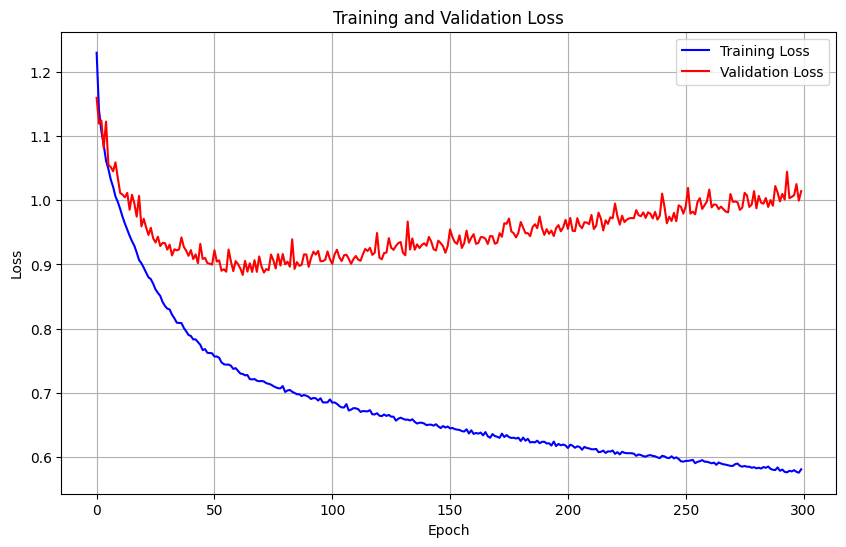

Fold 0: Best Validation Loss: 0.8837 at Epoch: 63
fold 1
Epoch: 2, Training Loss: 1.1358, Validation Loss: 1.1486
Epoch: 4, Training Loss: 1.0777, Validation Loss: 1.1125
Epoch: 6, Training Loss: 1.0422, Validation Loss: 1.0925
Epoch: 8, Training Loss: 1.0068, Validation Loss: 1.0801
Epoch: 10, Training Loss: 0.9845, Validation Loss: 1.0833
Epoch: 12, Training Loss: 0.9648, Validation Loss: 1.0510
Epoch: 14, Training Loss: 0.9422, Validation Loss: 1.0526
Epoch: 16, Training Loss: 0.9248, Validation Loss: 1.0327
Epoch: 18, Training Loss: 0.9073, Validation Loss: 1.0238
Epoch: 20, Training Loss: 0.8886, Validation Loss: 1.0042
Epoch: 22, Training Loss: 0.8784, Validation Loss: 0.9987
Epoch: 24, Training Loss: 0.8629, Validation Loss: 1.0039
Epoch: 26, Training Loss: 0.8539, Validation Loss: 1.0070
Epoch: 28, Training Loss: 0.8374, Validation Loss: 0.9869
Epoch: 30, Training Loss: 0.8306, Validation Loss: 0.9759
Epoch: 32, Training Loss: 0.8195, Validation Loss: 0.9777
Epoch: 34, Training

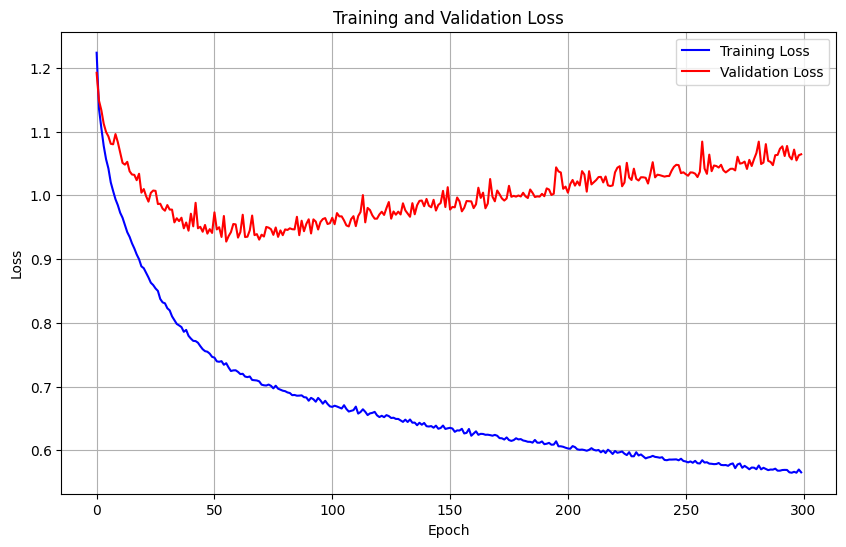

Fold 1: Best Validation Loss: 0.9274 at Epoch: 56
fold 2
Epoch: 2, Training Loss: 1.1353, Validation Loss: 1.1460
Epoch: 4, Training Loss: 1.0778, Validation Loss: 1.1087
Epoch: 6, Training Loss: 1.0386, Validation Loss: 1.0744
Epoch: 8, Training Loss: 1.0130, Validation Loss: 1.0637
Epoch: 10, Training Loss: 0.9889, Validation Loss: 1.0493
Epoch: 12, Training Loss: 0.9683, Validation Loss: 1.0465
Epoch: 14, Training Loss: 0.9439, Validation Loss: 1.0115
Epoch: 16, Training Loss: 0.9289, Validation Loss: 1.0120
Epoch: 18, Training Loss: 0.9135, Validation Loss: 0.9942
Epoch: 20, Training Loss: 0.8996, Validation Loss: 0.9981
Epoch: 22, Training Loss: 0.8818, Validation Loss: 0.9784
Epoch: 24, Training Loss: 0.8688, Validation Loss: 0.9649
Epoch: 26, Training Loss: 0.8573, Validation Loss: 0.9535
Epoch: 28, Training Loss: 0.8452, Validation Loss: 0.9556
Epoch: 30, Training Loss: 0.8347, Validation Loss: 0.9612
Epoch: 32, Training Loss: 0.8223, Validation Loss: 0.9466
Epoch: 34, Training

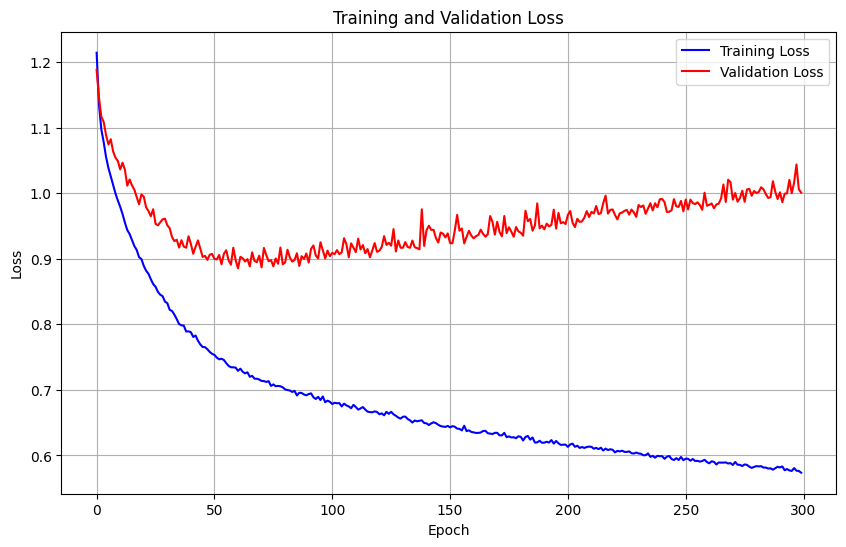

Fold 2: Best Validation Loss: 0.8854 at Epoch: 61
fold 3
Epoch: 2, Training Loss: 1.1415, Validation Loss: 1.1223
Epoch: 4, Training Loss: 1.0775, Validation Loss: 1.1424
Epoch: 6, Training Loss: 1.0460, Validation Loss: 1.0641
Epoch: 8, Training Loss: 1.0150, Validation Loss: 1.0391
Epoch: 10, Training Loss: 0.9932, Validation Loss: 1.0401
Epoch: 12, Training Loss: 0.9722, Validation Loss: 1.0320
Epoch: 14, Training Loss: 0.9494, Validation Loss: 0.9986
Epoch: 16, Training Loss: 0.9310, Validation Loss: 0.9956
Epoch: 18, Training Loss: 0.9158, Validation Loss: 1.0146
Epoch: 20, Training Loss: 0.8986, Validation Loss: 0.9800
Epoch: 22, Training Loss: 0.8842, Validation Loss: 0.9699
Epoch: 24, Training Loss: 0.8690, Validation Loss: 0.9782
Epoch: 26, Training Loss: 0.8618, Validation Loss: 0.9550
Epoch: 28, Training Loss: 0.8504, Validation Loss: 0.9418
Epoch: 30, Training Loss: 0.8363, Validation Loss: 0.9385
Epoch: 32, Training Loss: 0.8257, Validation Loss: 0.9326
Epoch: 34, Training

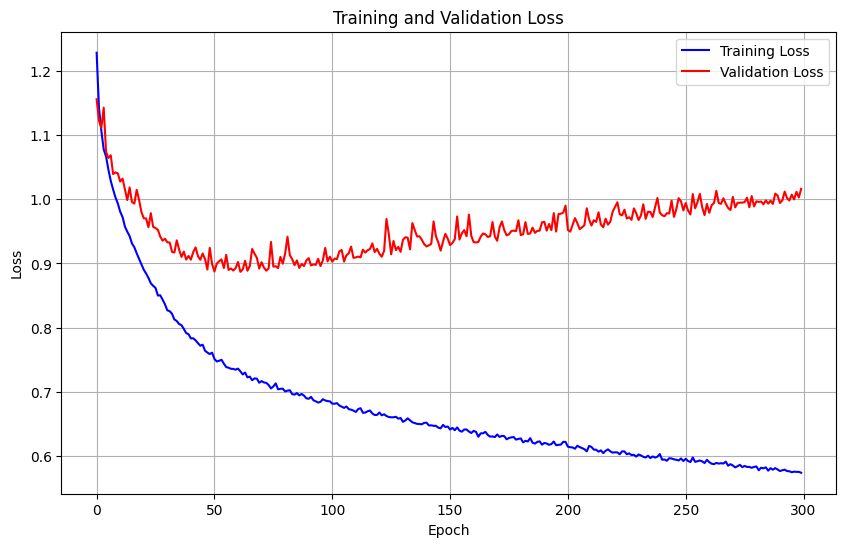

Fold 3: Best Validation Loss: 0.8869 at Epoch: 62
fold 4
Epoch: 2, Training Loss: 1.1455, Validation Loss: 1.1108
Epoch: 4, Training Loss: 1.0930, Validation Loss: 1.0658
Epoch: 6, Training Loss: 1.0549, Validation Loss: 1.0449
Epoch: 8, Training Loss: 1.0258, Validation Loss: 1.0314
Epoch: 10, Training Loss: 0.9977, Validation Loss: 0.9951
Epoch: 12, Training Loss: 0.9766, Validation Loss: 0.9949
Epoch: 14, Training Loss: 0.9563, Validation Loss: 0.9688
Epoch: 16, Training Loss: 0.9407, Validation Loss: 0.9851
Epoch: 18, Training Loss: 0.9269, Validation Loss: 0.9587
Epoch: 20, Training Loss: 0.9053, Validation Loss: 0.9540
Epoch: 22, Training Loss: 0.8920, Validation Loss: 0.9464
Epoch: 24, Training Loss: 0.8776, Validation Loss: 0.9290
Epoch: 26, Training Loss: 0.8684, Validation Loss: 0.9079
Epoch: 28, Training Loss: 0.8515, Validation Loss: 0.9122
Epoch: 30, Training Loss: 0.8390, Validation Loss: 0.9019
Epoch: 32, Training Loss: 0.8284, Validation Loss: 0.9065
Epoch: 34, Training

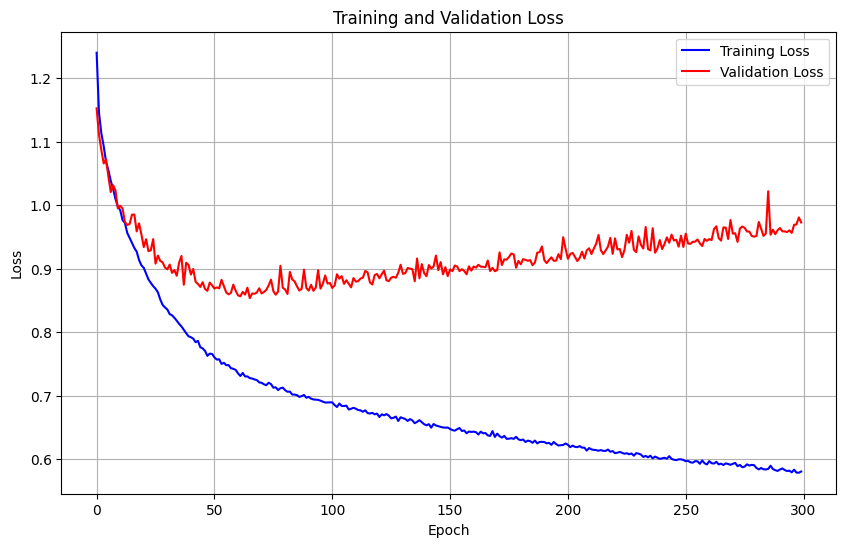

Fold 4: Best Validation Loss: 0.8536 at Epoch: 66


In [37]:



kf = KFold(n_splits=5, shuffle=True, random_state=CFG.seed)

l_best_loss = []
model_list = []



for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"fold {fold}")
    # 分割X和y为训练和验证集
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    #data cleaning
    lower_bound,upper_bound,median, X_train = data_cleaning(X_train)
    
    X_val = np.where(X_val < lower_bound, median, X_val)
    X_val = np.where(X_val > upper_bound, median, X_val)
    
    # 对每一折的训练数据计算均值和标准差
    scaler = StandardScaler().fit(X_train)
    
    # 标准化当前折的训练和验证数据
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # X_train_scaled = X_train
    # X_val_scaled = X_val
    
    # 接下来是构建train_ds和valid_ds
    # 注意，现在X_train_scaled和X_val_scaled应该用来构建相应的CustomDataset实例
    train_ds = CustomDataset(X_train_scaled, y_train)  # 假设CustomDataset可以接受X和y作为输入
    valid_ds = CustomDataset(X_val_scaled, y_val)
    
    train_loader = DataLoader(dataset=train_ds, shuffle=True, batch_size=CFG.batch_size)
    valid_loader = DataLoader(dataset=valid_ds,  shuffle=False,batch_size=64)
        
    # model = SimpleMultinomialModelKL_2(input_dim, hidden_dim=(input_dim//2), output_dim=6).to(device)
    # model.name = SimpleMultinomialModelKL_2
    
    
    model = SimpleMultinomialModelKL(input_dim, output_dim=6).to (device)
    model.name = "SimpleMultinomialModelKL"
    
    # model = TransformerModel(input_dim, hidden_dim = 512, output_dim = 6, nhead = 8, num_encoder_layers = 3, num_decoder_layers = 0).to(device)
    # model = SimpleMultinomialModelKL(input_dim,output_dim=6).to(device)
    # model.name = "SimpleMultinomialModelKL"
    
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
    criterion = nn.KLDivLoss(reduction='batchmean').to(device)
    
    
    model, train_losses, val_losses, best_val_loss, best_epoch = train_and_evaluate(
        model=model, 
        train_loader=train_loader, 
        valid_loader=valid_loader, 
        optimizer=optimizer, 
        criterion=criterion, 
        epochs=CFG.epochs, 
        device=device
    )
    model_list.append(model)
    plot_loss_curves(train_losses, val_losses, title='Training and Validation Loss', xlabel='Epoch', ylabel='Loss')
      
    l_best_loss.append(best_val_loss)
    print(f"Fold {fold}: Best Validation Loss: {best_val_loss:.4f} at Epoch: {best_epoch+1}")
    gc.collect()
log_training_results(log_path=LOG_PATH, 
                        model_name=model.name,  # 使用模型的name属性
                        params={'epoch': CFG.epochs, 'lr': CFG.lr, 'batch_size': CFG.batch_size}, 
                        results={'val_loss': round(sum(l_best_loss)/len(l_best_loss), 4), 'train_loss': "不想写", 'F1': None, 'accuracy': None},
                        random_state=CFG.seed, 
                        notes="stftdataclean之后train")

Train and visualize outcomes

In [32]:
# model_list, train_loss_total, val_loss_total = train_eeg_spec_cus(processed_sampler_data, batch_size=64, lr=0.0001, epochs=200,  random_state=48,device=device,save_model=False, save_path=os.path.join(CHECKPOINT_DIR, "{}.pth"))


In [33]:
#删除processed_sampler_data_original的后六列
# original_sampler = f"{PROCESSED_DATA_DIR}/spe_stft_sampler_50s_144img.pickle"
# with open(original_sampler, 'rb') as handle:
#     processed_sampler_data_original = pickle.load(handle)
    
# print(len(processed_sampler_data_original))

# processed_sampler_data_original = np.array(processed_sampler_data_original)
# processed_sampler_data_original  = processed_sampler_data_original [:,:-6]

# processed_sampler_data = np.array(processed_sampler_data)

# combined_data = np.concatenate((processed_sampler_data_original , processed_sampler_data), axis=1)

# print(f"合并后的数据形状: {np.shape(combined_data)}")


In [34]:
# combined_data = np.concatenate((processed_sampler_data_2, processed_sampler_data), axis=1)

In [35]:
# model_list, train_loss_total, val_loss_total = train_eeg_spec_cus(combined_data, batch_size=64, lr=0.0001, epochs=200, device=device,save_model=False, save_path=os.path.join(CHECKPOINT_DIR, "{}.pth"))

In [36]:
# for train_losses,val_losses in train_loss_total, val_loss_total:
#     plot_loss_curves(train_losses, val_losses, title='Training and Validation Loss', xlabel='Epoch', ylabel='Loss')
